## Project Setup

In [1]:
import os
import re
import bs4
import math
import requests
import warnings
import numpy as np
import pandas as pd
import sqlalchemy as db
import geopandas as gpd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
# the constants

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
UBER_CSV = "uber_rides_sample.csv"
WEATHER_CSV = ["2009_weather.csv", "2010_weather.csv", "2011_weather.csv", "2012_weather.csv", "2013_weather.csv", "2014_weather.csv", "2015_weather.csv"]

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries/"

## Part 1: Data Preprocessing

In Part1, we will preprocess the data. We will do the following steps:

1. Calculate the distance using latitude and longitude.
2. Download the yellow_tripdata_yyyy-mm.parquet from the NYC Taxi & Limousine Commission using `requests` library.
3. Load and clean the yellow taxi data frm 2009-01 to 2015-06.
4. Load and clean the uber data.
5. Load and clean the weather data from 2009-01 to 2015-06.

### Calculating distance

The most important thing in a trip is the distance, so we need to calculate the distance from the start to the end of the trip. Considering the earth is a sphere, we can use the Haversine formula to calculate the distance. The formula is:

$$
d = 2r\arcsin\left(\sqrt{\sin^2\left(\frac{\phi_2-\phi_1}{2}\right)+\cos\phi_1\cos\phi_2\sin^2\left(\frac{\lambda_2-\lambda_1}{2}\right)}\right)
$$

The $r$ is the radius of the earth, which is 6371 km. $\phi$ is the latitude, and $\lambda$ is the longitude. The formula is from [Wikipedia](https://en.wikipedia.org/wiki/Haversine_formula).

In [3]:
def calculate_distance(from_coord, to_coord):
    """
    Calculate the distance between two coordinates in kilometers.
    args:
        from_coord: dataframe of columns 'pickup_latitude' and 'pickup_longitude'
        to_coord: dataframe of columns 'dropoff_latitude' and 'dropoff_lo ngitude'
    returns:
        distance in kilometers
    """
    pickup_lat = from_coord['pickup_latitude'].map(math.radians)
    pickup_lon = from_coord['pickup_longitude'].map(math.radians)
    dropoff_lat = to_coord['dropoff_latitude'].map(math.radians)
    dropoff_lon = to_coord['dropoff_longitude'].map(math.radians)
    R = 6371 # Radius of earth in KM
    a = pickup_lat - dropoff_lat
    b = pickup_lon - dropoff_lon
    c = ((a / 2).map(math.sin)) ** 2 + pickup_lat.map(math.cos) * dropoff_lat.map(math.cos) * ((b / 2).map(math.sin) ** 2)
    distance = 2 * R * c.map(math.sqrt).map(math.asin)

    return distance.astype('float32')

In [4]:
def add_distance_column(dataframe):
    '''
    Adds a column to the dataframe with the distance between the pickup and dropoff coordinates.
    args:
        dataframe: a pandas dataframe with columns "pickup_latitude" , "pickup_longitude",  "dropoff_latitude" and "dropoff_longitude"
    returns:
        a copy of the dataframe with an additional column "distance" containing the distance between the pickup and dropoff coordinates
    '''

    from_coord = dataframe[['pickup_latitude', 'pickup_longitude']]
    to_coord = dataframe[['dropoff_latitude', 'dropoff_longitude']]
    dataframe['distance'] = calculate_distance(from_coord, to_coord)

    # remove any rows where the distance is bigger than 100 km
    dataframe = dataframe[dataframe['distance'] < 100]
    
    return dataframe

### Processing Taxi Data

We will load and clean the yellow taxi data from 2009-01 to 2009-06.

In [5]:
def find_taxi_parquet_urls():
    '''
    Finds the urls of the parquet files for the taxi data.
    returns:
        a list of urls
    '''
    strhtml = requests.get(TAXI_URL)
    soup = bs4.BeautifulSoup(strhtml.text, "html.parser")
    links = soup.find_all("a", href=True)

    urls = []
    for link in links:
        # use regular expression to find the links that match the pattern 2009-01~2015-06
        if re.search(r"yellow_tripdata_2009|yellow_tripdata_201[0-4]|yellow_tripdata_2015-0[1-6]", link.get("href")):
            urls.append(link.get("href"))
    return urls


In [50]:
geo = gpd.read_file(filename='taxi_zones.zip', engine='fiona')
geo = geo.to_crs(4326)
# get the coordinates of the pickup and dropoff locations
geo['longitude'] = geo.centroid.x
geo['latitude'] = geo.centroid.y
# some location IDs are duplicated so those IDs are removed 
geo.drop_duplicates('LocationID',inplace=True)
geo.set_index('LocationID',inplace=True)

In [7]:
def get_and_clean_month_taxi_data(url):
    '''
    Downloads the taxi data for a given month and cleans it.
    args:
        url: the url of the parquet file
    returns:
        a pandas dataframe with the cleaned data
    '''
    file_name = url.split('/')[-1]

    # download the file if it doesn't exist
    if not os.path.exists(file_name):
        print("downloading", file_name)
        file = requests.get(url)
        with open(file_name , "wb") as f:
            f.write(file.content)

    df = pd.read_parquet(file_name)
    print("cleaning", file_name)

    # looking up the latitude and longitude for some months where only location IDs are given for pickups and dropoffs
    if 'PULocationID' in df.columns:
        df['pickup_latitude'] = df['PULocationID'].map(geo['latitude'])
        df['pickup_longitude'] = df['PULocationID'].map(geo['longitude'])
        df['dropoff_latitude'] = df['DOLocationID'].map(geo['latitude'])
        df['dropoff_longitude'] = df['DOLocationID'].map(geo['longitude'])

    # normalizing column names
    df.rename(columns={'tpep_pickup_datetime':'pickup_datetime','Trip_Pickup_DateTime':'pickup_datetime','Trip_Dropoff_DateTime':'dropoff_datetime','Start_Lon':'pickup_longitude', 'Start_Lat':'pickup_latitude', 'End_Lon':'dropoff_longitude', 'End_Lat':'dropoff_latitude','Tip_Amt':'tip_amount'}, inplace=True)

    # some location IDs are valid so those specific trips are removed 
    df.dropna(subset=['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],inplace=True)

    # removing unnecessary columns
    df = df[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','tip_amount']]

    # removing invalid data points
    df = df[df['tip_amount'] >= 0]

    # removing trips that start and/or end outside of the NEW_YORK_BOX_COORDS
    df = df[(df['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (df['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    df = df[(df['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (df['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]

    # sample the data to make it roughly equal to the size of the Uber dataset
    # ~200000 is the number of rows in the Uber dataset
    # so every month we sample 200000 / 78 = 2564 rows
    df = df.sample(n=2564)

    # normalizing and using appropriate column types for the respective data
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df = df.astype({'pickup_longitude':'float32','pickup_latitude':'float32','dropoff_longitude':'float32','dropoff_latitude':'float32','tip_amount':'float32'})

    return df
    

In [8]:
def get_and_clean_taxi_data():
    '''
    Downloads the taxi data and cleans it.
    returns:
        a pandas dataframe with the cleaned taxi data
    '''
    all_taxi_dataframes = []
    
    all_parquet_urls = find_taxi_parquet_urls()
    for parquet_url in all_parquet_urls:
        dataframe = get_and_clean_month_taxi_data(parquet_url)
        add_distance_column(dataframe)

        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data

### Processing Uber Data

Now we should process the Uber data. We should make sure that the data is in the same format as the taxi data.

In [9]:
def load_and_clean_uber_data(csv_file):
    '''
    Loads the Uber data and cleans it.
    args:
        csv_file: the csv file with the Uber data
    returns:
        a pandas dataframe with the cleaned Uber data
    '''
    df = pd.read_csv(csv_file)
    print("cleaning", csv_file)
    
    # removing unnecessary columns
    df = df[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]

    # removing trips that start and/or end outside of the NEW_YORK_BOX_COORDS
    df = df[(df['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (df['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    df = df[(df['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (df['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]

    # normalizing and using appropriate column types for the respective data
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df = df.astype({'pickup_longitude':'float32','pickup_latitude':'float32','dropoff_longitude':'float32','dropoff_latitude':'float32'})
    
    return df

In [10]:
def get_uber_data():
    '''
    Load Uber data and cleans it.
    returns:
        a pandas dataframe with the cleaned Uber data
    '''
    if os.path.exists(UBER_CSV.replace('.csv','_cleaned.csv')):
        print("reading", UBER_CSV.replace('.csv','_cleaned.csv'))
        return pd.read_csv(UBER_CSV.replace('.csv','_cleaned.csv'))

    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    
    return uber_dataframe

### Processing Weather Data

We will load and clean the weather data from 2009~2015.

In [11]:
def clean_month_weather_data_hourly(csv_file):
    '''
    Loads the weather data and cleans it.
    args:
        csv_file: the csv file with the weather data
    returns:
        a pandas dataframe with the cleaned weather data
    '''
    df = pd.read_csv(csv_file)
    
    # removing unnecessary columns
    df = df[['DATE','HourlyWindSpeed','HourlyPrecipitation']]
    
    # normalizing and using appropriate column types for the respective data
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors='coerce')

    # fill in missing values
    mean = int(df['HourlyWindSpeed'].mean())
    df['HourlyWindSpeed'].fillna(mean, inplace=True)
    df['HourlyPrecipitation'].fillna(0, inplace=True)

    df = df.astype({'HourlyWindSpeed': 'int8', 'HourlyPrecipitation': 'float64'})

    return df

In [12]:
def clean_month_weather_data_daily(csv_file):
    '''
    Loads the weather data and groups it by day.
    args:
        csv_file: the csv file with the weather data
    returns:
        a pandas dataframe with the cleaned weather data
    '''
    df = clean_month_weather_data_hourly(csv_file)

    # group by hour and take the mean of the windspeed and sum of the precipitation
    df['DATE'] = df['DATE'].dt.date
    df = df.groupby('DATE').agg({'HourlyWindSpeed': np.mean, 'HourlyPrecipitation': np.sum})

    # normalizing and using appropriate column types for the respective data
    df.reset_index(inplace=True)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.rename(columns={'HourlyWindSpeed': 'DailyWindSpeed', 'HourlyPrecipitation': 'DailyPrecipitation'}, inplace=True)
    df = df.astype({'DailyWindSpeed':'int8','DailyPrecipitation':'float64'})
    
    return df

In [13]:
def load_and_clean_weather_data():
    '''
    Loads the weather data and cleans it.
    returns:
        a pandas dataframe with the cleaned weather data
    '''

    hourly_dataframes = []
    daily_dataframes = []

    for csv_file in WEATHER_CSV:
        print("cleaning", csv_file)
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        daily_dataframes.append(daily_dataframe)

    # create two dataframes with data from every month needed
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)

    return hourly_data, daily_data

### Process All Data

Now we can process all the data.

In [14]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

cleaning yellow_tripdata_2015-01.parquet
cleaning yellow_tripdata_2015-02.parquet
cleaning yellow_tripdata_2015-03.parquet
cleaning yellow_tripdata_2015-04.parquet
cleaning yellow_tripdata_2015-05.parquet
cleaning yellow_tripdata_2015-06.parquet
cleaning yellow_tripdata_2014-01.parquet
cleaning yellow_tripdata_2014-02.parquet
cleaning yellow_tripdata_2014-03.parquet
cleaning yellow_tripdata_2014-04.parquet
cleaning yellow_tripdata_2014-05.parquet
cleaning yellow_tripdata_2014-06.parquet
cleaning yellow_tripdata_2014-07.parquet
cleaning yellow_tripdata_2014-08.parquet
cleaning yellow_tripdata_2014-09.parquet
cleaning yellow_tripdata_2014-10.parquet
cleaning yellow_tripdata_2014-11.parquet
cleaning yellow_tripdata_2014-12.parquet
cleaning yellow_tripdata_2013-01.parquet
cleaning yellow_tripdata_2013-02.parquet
cleaning yellow_tripdata_2013-03.parquet
cleaning yellow_tripdata_2013-04.parquet
cleaning yellow_tripdata_2013-05.parquet
cleaning yellow_tripdata_2013-06.parquet
cleaning yellow_

## Part 2: Storing Cleaned Data

When we get the cleaned data, we should store it in a database.

In [4]:
engine = db.create_engine(DATABASE_URL)

In [16]:
HOURLY_WEATHER_SCHEMA = """CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    HourlyWindSpeed INT8,
    HourlyPrecipitation FLOAT64
);
"""

DAILY_WEATHER_SCHEMA = """CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE ,
    DailyWindSpeed INT8,
    DailyPrecipitation FLOAT64
);
"""

TAXI_TRIPS_SCHEMA = """CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    PULocationID INT8,
    DOLocationID INT8,
    pickup_longitude FLOAT32,
    pickup_latitude FLOAT32,
    dropoff_longitude FLOAT32,
    dropoff_latitude FLOAT32,
    tip_amount FLOAT32,
    distance FLOAT32
);
"""

UBER_TRIPS_SCHEMA = """CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    pickup_longitude FLOAT32,
    pickup_latitude FLOAT32,
    dropoff_longitude FLOAT32,
    dropoff_latitude FLOAT32,
    distance FLOAT32
);
"""

In [17]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [18]:
# create the tables with the schema files
with engine.connect() as connection:
    with open(DATABASE_SCHEMA_FILE, "r") as f:
        lines = f.readlines()
        query = []
        for line in lines:
            query.append(line)
            # if the line is a semicolon, execute the query
            if ";" in line:
                connection.execute(db.text("".join(query)))
                query = []

### Add Data to Database

After we create the database, we can add the data to it.

In [19]:
def write_dataframes_to_table(table_to_df_dict):
    '''
    Writes the dataframes to the database.
    args:
        table_to_df_dict: a dictionary mapping table names to dataframes
    '''
    for table, df in table_to_df_dict.items():
        print("writing", table)
        df.to_sql(table, engine, if_exists='append', index=False)

In [20]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [21]:
write_dataframes_to_table(map_table_name_to_dataframe)

writing taxi_trips
writing uber_trips
writing hourly_weather
writing daily_weather


## Part 3: Understanding the Data

After we store the data in the database, we can query the data from the database.

In [8]:
def write_query_to_file(query, outfile):
    '''
    Writes the query to the outfile.
    args:
        query: the query to write
        outfile: the name of the file to write to
    '''
    with open(QUERY_DIRECTORY + '/' + outfile, "w") as f:
        f.write(query)

### Query 1

For 01-2009 through 06-2015, we will find the most popular hour of the day to take a yellow taxi.

In [9]:
QUERY_1 = """SELECT strftime('%H', pickup_datetime) AS time, COUNT(*) AS num
FROM taxi_trips
GROUP BY time
ORDER BY num DESC;
"""

In [10]:
engine.execute(QUERY_1).fetchall()

[('19', 12496),
 ('18', 12078),
 ('20', 11748),
 ('21', 11381),
 ('22', 11109),
 ('14', 10136),
 ('17', 9993),
 ('23', 9890),
 ('13', 9839),
 ('12', 9814),
 ('15', 9641),
 ('09', 9453),
 ('11', 9329),
 ('10', 9091),
 ('08', 9075),
 ('16', 8180),
 ('00', 7758),
 ('07', 7193),
 ('01', 5899),
 ('02', 4427),
 ('06', 3934),
 ('03', 3190),
 ('04', 2381),
 ('05', 1957)]

In [11]:
write_query_to_file(QUERY_1, "most_popular_hour.sql")

### Query 2

For 01-2009 through 06-2015, we will find the most popular day of the week to take a yellow taxi.

In [12]:
QUERY_2 = """SELECT strftime('%w', pickup_datetime) AS day, COUNT(*) AS num
FROM taxi_trips
GROUP BY day
ORDER BY num DESC;
"""

In [13]:
engine.execute(QUERY_2).fetchall()

[('5', 30884),
 ('6', 30406),
 ('4', 30017),
 ('3', 28705),
 ('2', 28100),
 ('0', 26432),
 ('1', 25448)]

In [14]:
write_query_to_file(QUERY_2, "most_popular_day.sql")

### Query 3

We will find the 95% percentile of distance traveled for all hired trips during July 2013.

In [15]:
QUERY_3 = """WITH hired_trips AS (SELECT pickup_datetime,distance 
      FROM taxi_trips 
      WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-08-01'
      UNION ALL
      SELECT pickup_datetime,distance FROM uber_trips
      WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-08-01')
SELECT distance
FROM hired_trips
ORDER BY distance ASC
LIMIT 1
OFFSET (SELECT COUNT(*) FROM hired_trips) * 95 / 100 - 1 ;
"""

In [16]:
engine.execute(QUERY_3).fetchall()

[(10.775696754455566,)]

In [17]:
write_query_to_file(QUERY_3, "95%_percentile_distance.sql")

### Query 4

We will find the top 10 days with the highest number of hired rides for 2009, and the average distance for each day.

In [19]:
QUERY_4 = """WITH hired_trips AS (SELECT pickup_datetime,distance 
      FROM taxi_trips 
      WHERE pickup_datetime BETWEEN '2009-01-01' AND '2010-01-01'
      UNION ALL
      SELECT pickup_datetime,distance FROM uber_trips
      WHERE pickup_datetime BETWEEN '2009-01-01' AND '2010-01-01'
)
SELECT date(pickup_datetime) AS date, AVG(distance) AS avg_distance, COUNT(*) AS num
FROM hired_trips
GROUP BY date
ORDER BY num DESC
LIMIT 10;
"""

In [20]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 2.808547719916852, 228),
 ('2009-08-14', 3.2059291558318557, 226),
 ('2009-06-05', 2.887434742227197, 225),
 ('2009-11-06', 3.40713423057749, 217),
 ('2009-10-23', 2.751567650360273, 216),
 ('2009-12-05', 2.970049008883016, 215),
 ('2009-03-06', 2.7032135709980283, 213),
 ('2009-02-20', 2.9698631424681428, 212),
 ('2009-01-31', 2.61758047492025, 209),
 ('2009-12-04', 2.7607149054081392, 208)]

In [21]:
write_query_to_file(QUERY_4, "top_10_days.sql")

### Query 5

We will find the top 10 windiest days in 2014, and the number of hired trips on those days.

In [22]:
QUERY_5 = """SELECT date(pickup_datetime) AS date, COUNT(*) AS num
FROM (SELECT pickup_datetime FROM taxi_trips
      UNION ALL
      SELECT pickup_datetime FROM uber_trips)
GROUP BY date
HAVING date IN (SELECT date(DATE) FROM daily_weather WHERE DATE BETWEEN '2014-01-01' AND '2015-01-01' ORDER BY DailyWindSpeed DESC LIMIT 10)
"""

In [23]:
engine.execute(QUERY_5).fetchall()

[('2014-01-02', 121),
 ('2014-01-03', 92),
 ('2014-01-07', 165),
 ('2014-02-13', 130),
 ('2014-03-13', 195),
 ('2014-03-26', 185),
 ('2014-03-29', 211),
 ('2014-12-07', 172),
 ('2014-12-08', 174),
 ('2014-12-09', 153)]

In [24]:
write_query_to_file(QUERY_5, "top_10_windiest_days.sql")

### Query 6

We will find the number of trips taken each hour during the week leading up to Hurricane Sandy(Oct 29-30, 2012), and the hourly precipitation and wind speed during for each hour.

In [26]:
QUERY_6 = """WITH hired_trips AS (SELECT strftime('%Y-%m-%d %H:00:00:00',pickup_datetime) AS DATE
      FROM taxi_trips
      WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-10-31'
      UNION ALL
      SELECT pickup_datetime FROM uber_trips
      WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-10-31')
SELECT strftime('%Y-%m-%d %H:00:00:00',hourly_weather.DATE) AS WDATE, COALESCE(COUNT(hired_trips.DATE),0) AS num, HourlyPrecipitation, HourlyWindSpeed
FROM hourly_weather
LEFT JOIN hired_trips
ON WDATE = hired_trips.DATE
WHERE WDATE BETWEEN '2012-10-22' AND '2012-10-31'
GROUP BY WDATE
"""

In [27]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22 00:00:00:00', 1, 0.0, 7),
 ('2012-10-22 01:00:00:00', 2, 0.0, 5),
 ('2012-10-22 02:00:00:00', 1, 0.0, 7),
 ('2012-10-22 03:00:00:00', 2, 0.0, 0),
 ('2012-10-22 04:00:00:00', 1, 0.0, 0),
 ('2012-10-22 05:00:00:00', 1, 0.0, 0),
 ('2012-10-22 06:00:00:00', 3, 0.0, 5),
 ('2012-10-22 07:00:00:00', 1, 0.0, 3),
 ('2012-10-22 08:00:00:00', 4, 0.0, 3),
 ('2012-10-22 09:00:00:00', 4, 0.0, 5),
 ('2012-10-22 10:00:00:00', 3, 0.0, 5),
 ('2012-10-22 11:00:00:00', 3, 0.0, 5),
 ('2012-10-22 12:00:00:00', 2, 0.0, 11),
 ('2012-10-22 13:00:00:00', 1, 0.0, 5),
 ('2012-10-22 14:00:00:00', 6, 0.0, 7),
 ('2012-10-22 15:00:00:00', 1, 0.0, 6),
 ('2012-10-22 16:00:00:00', 5, 0.0, 3),
 ('2012-10-22 17:00:00:00', 2, 0.0, 7),
 ('2012-10-22 18:00:00:00', 10, 0.0, 5),
 ('2012-10-22 19:00:00:00', 11, 0.0, 5),
 ('2012-10-22 20:00:00:00', 5, 0.0, 3),
 ('2012-10-22 21:00:00:00', 6, 0.0, 0),
 ('2012-10-22 22:00:00:00', 6, 0.0, 3),
 ('2012-10-22 23:00:00:00', 8, 0.0, 3),
 ('2012-10-23 00:00:00:00', 3, 0.0, 3

In [28]:
write_query_to_file(QUERY_6, "hurricane_sandy.sql")

## Part 4: Visualizing the Data

### Visualization 1

We will create an bar chart to show the most popular hour of the day to take a yellow taxi. The bar chart can show us the relative popularity of each hour.

In [29]:
def hour_for_taxi_trip(dataframe):
    '''
    Returns the most popular hour of the day for taxi trips.
    args:
        dataframe: the taxi dataframe
    '''
    dataframe.plot(x="time", y="num",kind="bar", title="Num of Taxi Trips per Hour", xlabel="Hour", ylabel="Number of Trips")

In [30]:
def get_data_for_visual_1():
    '''
    Returns the data for the first visualization.
    '''
    df = pd.read_sql_query(QUERY_1, engine)
    return df

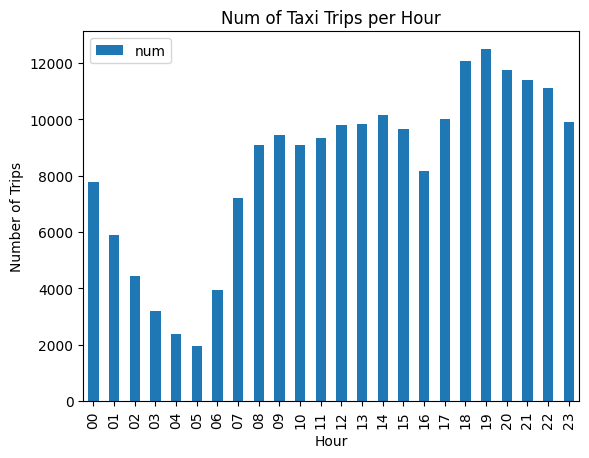

In [31]:
some_dataframe = get_data_for_visual_1()
hour_for_taxi_trip(some_dataframe.sort_values(by="time", ascending=True))

### Visualization 2

We will create an bar chart to show the average distance traveled per month. The bar chart can speed up our understanding of the data.


In [32]:
def month_for_all_trips(dataframe):
    '''
    Plot an bar chart to show the average distance traveled per month.
    args:
        dataframe: the average distance per month dataframe
    '''
    dataframe.plot(x="month", y="avg_distance", kind="bar", title="Average Distance Traveled per Month", xlabel="Month", ylabel="Average Distance Traveled")

In [36]:
# get the data from the database
def get_data_for_visual_2():
    '''
    Returns the average distance per month dataframe.
    '''
    query = '''WITH hired_trips AS (SELECT pickup_datetime,distance
    FROM taxi_trips UNION ALL
    SELECT pickup_datetime,distance FROM uber_trips)
    SELECT strftime('%m', pickup_datetime) AS month, AVG(year_month_distance) AS avg_distance
    FROM (SELECT pickup_datetime, SUM(distance) AS year_month_distance
    FROM hired_trips
    GROUP BY strftime('%Y-%m', pickup_datetime))
    GROUP BY month;
    '''
    df = pd.read_sql_query(query, engine)
    return df

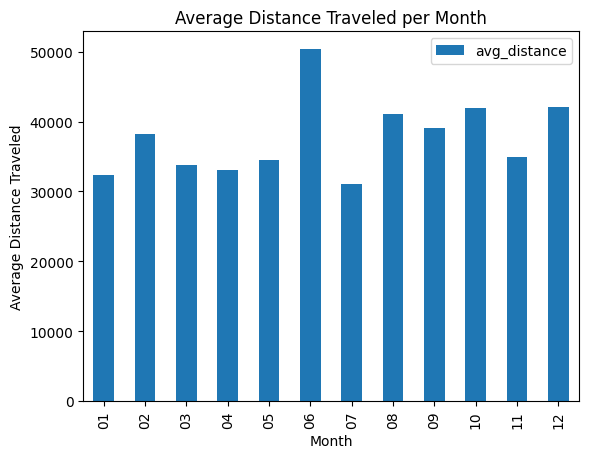

In [37]:
some_dataframe = get_data_for_visual_2()
month_for_all_trips(some_dataframe)

### Visualization 3

Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR and create a multi-bar chart that compares what day of the week was most popular for drop offs for each airport. The multi-bar chart can show us the most popular day of the week for each airport simultaneously.

In [41]:
def dropoff_num_for_each_day(dataframes):
    '''
    Plot a line chart to show the number of dropoffs for each day.
    '''
    dataframes[0]['JFK'] = dataframes[1]['JFK']
    dataframes[0]['EWR'] = dataframes[2]['EWR']
    dataframes[0].plot(x="day", y=["LGA",'JFK','EWR'], kind="bar", title="Number of Dropoffs for Each Day for each Airport", xlabel="Day", ylabel="Number of Dropoffs")

In [42]:
def get_data_for_visual_3():
    '''
    Returns the number of dropoffs for each day of the week for each airport.
    '''
    LGA_BBOX = [-73.889473,40.766102,-73.857630,40.782806,'LGA']
    JFK_BBOX = [-73.826978,40.618945,-73.741319,40.673388,'JFK']
    EWR_BBOX = [-74.199343,40.668791,-74.150248,40.712069,'EWR']
    df = []
    for BBOX in [LGA_BBOX, JFK_BBOX, EWR_BBOX]:
        query = f'''WITH hired_trips AS (SELECT pickup_datetime,dropoff_longitude,dropoff_latitude
        FROM taxi_trips UNION ALL
        SELECT pickup_datetime,dropoff_longitude,dropoff_latitude FROM uber_trips)
        SELECT strftime('%w', pickup_datetime) AS day ,COUNT(*) AS {BBOX[4]}
        FROM hired_trips
        WHERE dropoff_longitude BETWEEN {BBOX[0]} AND {BBOX[2]} AND dropoff_latitude BETWEEN {BBOX[1]} AND {BBOX[3]}
        GROUP BY day
        '''
        df.append(pd.read_sql_query(query, engine))
    return df

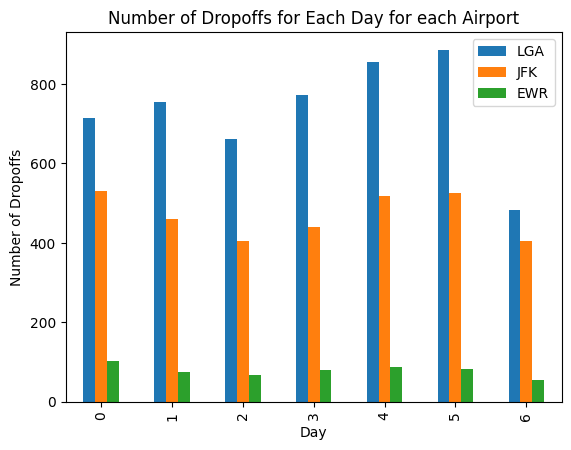

In [43]:
some_dataframe = get_data_for_visual_3()
dropoff_num_for_each_day(some_dataframe)

### Visualization 4

Create a heatmap of all hired trips over a map of the area. The heatmap can show us the density of the hired trips in the area.

In [45]:
def heatmap_for_trips(dataframe):
    '''
    Make a heatmap of all hired trips over a map of the area.
    args:
        dataframe: the dataframe
    '''
    # reindex the geo
    geo_loc = geo.reset_index()

    # make a key from the latitude and longitude
    geo_loc['key'] = geo_loc['latitude'] ** 2 +  geo_loc['longitude'] ** 2
    dataframe['key'] = dataframe['latitude'] ** 2 +  dataframe['longitude'] ** 2

    # sort the key
    geo_loc.sort_values(by='key', inplace=True)
    dataframe.sort_values(by='key', inplace=True)

    # join the two dataframes
    dataframe = pd.merge_asof(dataframe, geo_loc, left_on=["key"],right_on=["key"])
    dataframe.dropna(subset=["LocationID"], inplace=True)

    geo_loc['num'] = dataframe.groupby("LocationID").count()['key']
    geo_loc.plot(column='num', cmap='coolwarm', legend=False)
    plt.axis('off')
    plt.show()

In [46]:
def get_data_for_visual_4():
    '''
    Returns the data for the visualization.
    '''

    query = '''WITH hired_trips AS (SELECT pickup_latitude AS latitude, pickup_longitude AS longitude
    FROM taxi_trips UNION ALL
    SELECT pickup_latitude AS latitude, pickup_longitude AS longitude FROM uber_trips)
    SELECT latitude, longitude
    FROM hired_trips
    '''
    df = pd.read_sql_query(query, engine)

    return df

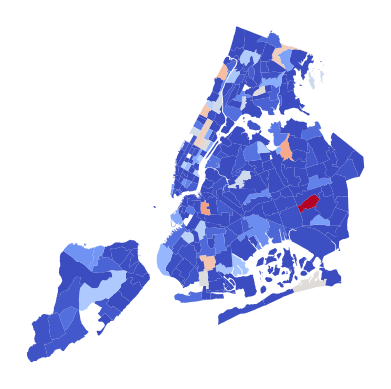

In [51]:
some_dataframe = get_data_for_visual_4()
heatmap_for_trips(some_dataframe)

### Visualization 5

Create a scatter plot that compares tip amount versus distance. A scatter plot can show us the relationship between tip amount and distance.

In [55]:
# use a more descriptive name for your function
def tip_amount_vs_distance(dataframe):
    '''
    Create a scatter plot that compares tip amount versus distance.
    '''
    # sample the data to make the scatter plot clearer
    dataframe[(dataframe['distance'] < 100) & (dataframe['tip_amount'] < 100)].sample(200).plot(x="distance", y="tip_amount", kind="scatter", title="Tip Amount vs Distance", xlabel="Distance", ylabel="Tip Amount")

In [56]:
def get_data_for_visual_5():
    '''
    Returns the data for the visualization.
    '''

    query = '''SELECT tip_amount, distance
    FROM taxi_trips
    '''
    df = pd.read_sql_query(query, engine)
    return df

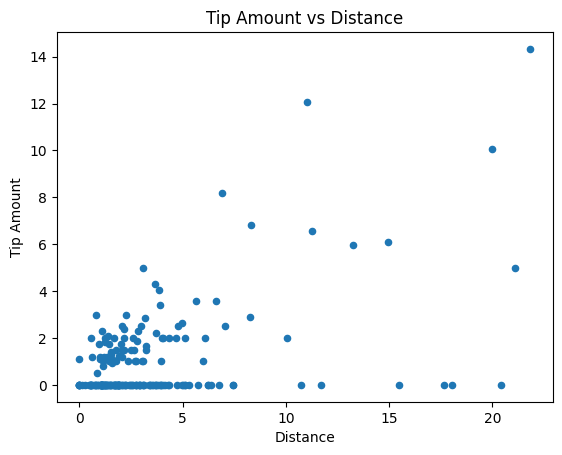

In [57]:
some_dataframe = get_data_for_visual_5()
tip_amount_vs_distance(some_dataframe)

### Visualization 6

Create another scatter plot that compares tip amount versus precipitation amount.

In [79]:
def tip_amount_vs_precipitation(dataframe):
    '''
    Create another scatter plot that compares tip amount versus precipitation amount.
    '''

    df = pd.merge(dataframe[0], dataframe[1], on='DATE')
    df = df[(df['precipitation'] > 0)]
    
    # sample the data to make the scatter plot clearer
    df.sample(200).plot(x="precipitation", y="tip_amount", kind="scatter", title="Tip Amount vs Precipitation", xlabel="Precipitation", ylabel="Tip Amount")
    

In [80]:
def get_data_for_visual_6():
    '''
    Returns the data for the visualization.
    '''
    
    df = []
    query1 = '''
    SELECT strftime('%Y-%m-%d', pickup_datetime) AS DATE, SUM(taxi_trips.tip_amount) AS tip_amount
    FROM taxi_trips
    GROUP BY strftime('%Y-%m-%d', pickup_datetime)
    ''' 
    query2 ='''
    SELECT strftime('%Y-%m-%d', DATE) AS DATE, DailyPrecipitation AS precipitation
    FROM daily_weather
    '''
    df.append(pd.read_sql_query(query1, engine))
    df.append(pd.read_sql_query(query2, engine))

    return df

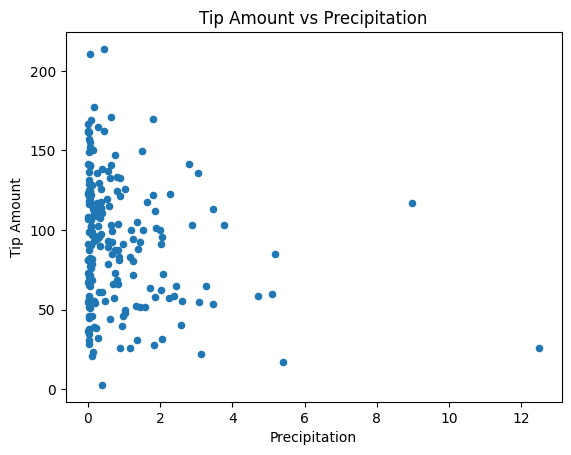

In [81]:
some_dataframe = get_data_for_visual_6()
tip_amount_vs_precipitation(some_dataframe)